<a href="https://colab.research.google.com/github/hemantnyadav/deepar_gluonts/blob/main/DeepAR_on_Multiple_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install --upgrade mxnet==1.6.0
#!pip install gluonts

In [6]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
#!unzip LD2011_2014.txt.zip

In [47]:
#!head LD2011_2014.txt

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gluonts.mx import DeepAREstimator, Trainer

/usr/local/lib/python3.8/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [11]:
df = pd.read_csv("LD2011_2014.txt", sep=';', index_col=0, parse_dates=True, decimal=',')
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df.shape

(140256, 370)

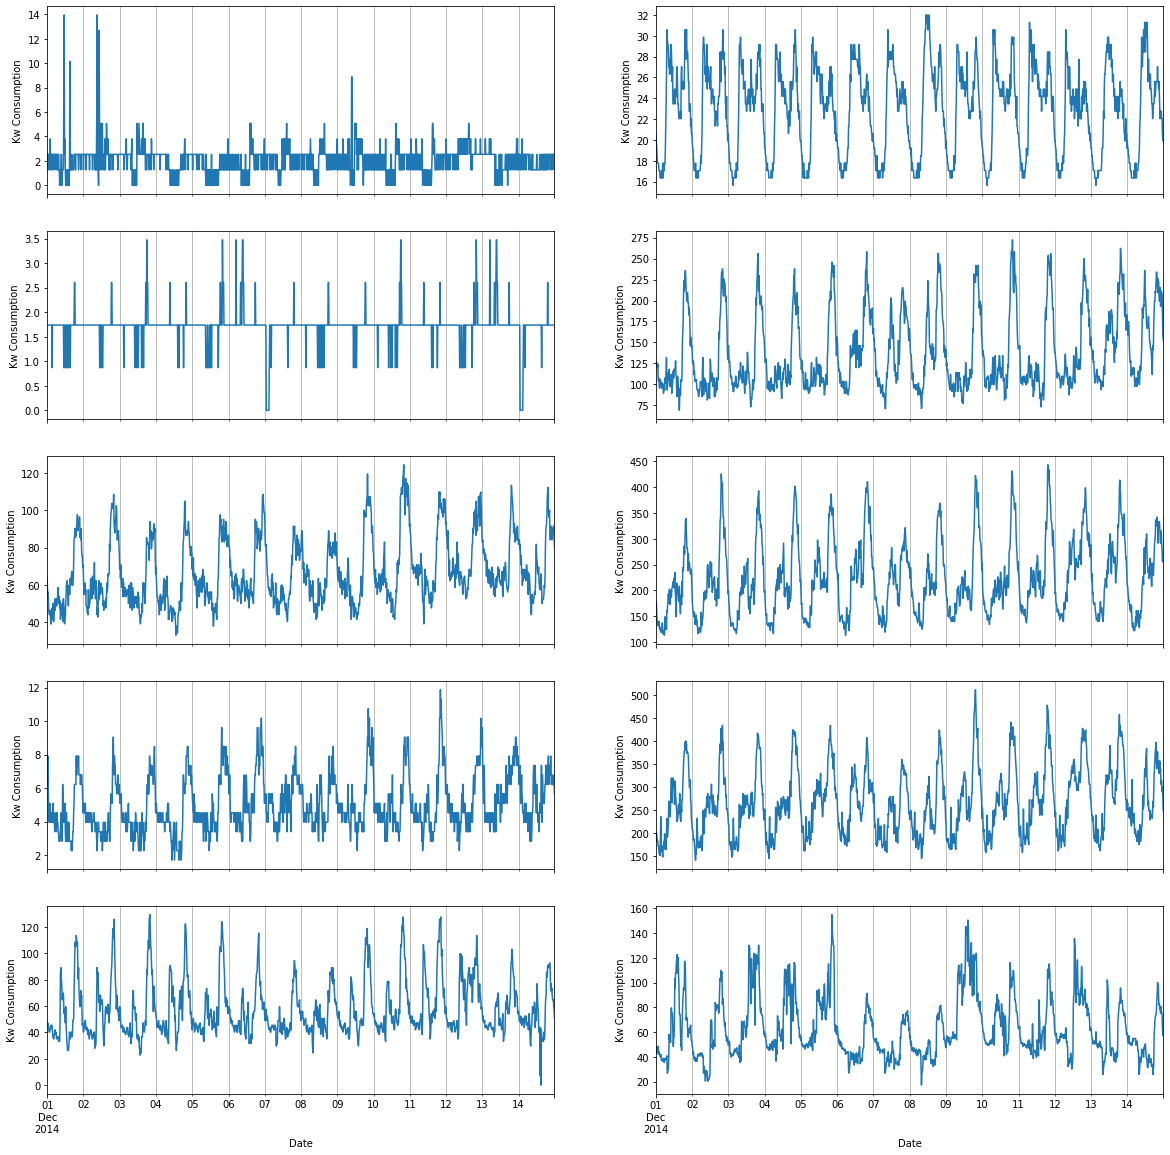

In [14]:
fix, axs=plt.subplots(5,2,figsize=(20,20),sharex=True)
axx = axs.ravel()
for i in range(0,10):
  df[df.columns[i]].loc['2014-12-01':'2014-12-14'].plot(ax=axx[i])
  axx[i].set_xlabel('Date')
  axx[i].set_ylabel('Kw Consumption')
  axx[i].grid(which='minor', axis='x')

In [15]:
df_input = df.reset_index(drop=True).T.reset_index()

In [16]:
df_input.head()

,index,0,1,2,3,4,5,6,7,8,...,140246,140247,140248,140249,140250,140251,140252,140253,140254,140255
0,MT_001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.538071,1.269036,2.538071,2.538071,1.269036,2.538071,2.538071,2.538071,1.269036,2.538071
1,MT_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.048364,22.048364,22.048364,22.048364,22.048364,22.048364,21.337127,20.625889,21.337127,19.914651
2,MT_003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619
3,MT_004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,156.504065,164.634146,160.569106,162.601626,156.504065,150.406504,166.666667,162.601626,166.666667,178.861789
4,MT_005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,86.585366,93.902439,87.804878,80.487805,85.365854,85.365854,81.707317,82.926829,85.365854,84.146341


In [18]:
ts_code = df_input['index'].astype('category').cat.codes.values

In [21]:
df_train = df_input.iloc[:,1:134999].values
df_test = df_input.iloc[:,134999:].values

In [22]:
print(df_train.shape, df_test.shape)

(370, 134998) (370, 5258)


In [26]:
freq= '15min'
start_train = pd.Timestamp("2011-01-01 00:15:00", freq = freq) 
start_test = pd.Timestamp("2014-11-07 05:30:00", freq = freq) 
prediction_length = 672

<ipython-input-26-b715ebe7e88b>:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_train = pd.Timestamp("2011-01-01 00:15:00", freq = freq)
<ipython-input-26-b715ebe7e88b>:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_test = pd.Timestamp("2014-11-07 05:30:00", freq = freq)


In [27]:
estimator = DeepAREstimator( freq = "10min",
                            context_length = 672,
                            prediction_length = prediction_length,
                            use_feat_static_cat = True,
                            cardinality = [1],
                            num_layers= 2,
                            num_cells= 32,
                            cell_type='lstm',
                            trainer = Trainer(epochs=5)
                            )



In [29]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start_train,
            FieldName.FEAT_STATIC_CAT: fsc
        }for(target,fsc) in zip(df_train[0:7],ts_code[0:7].reshape(-1,1))
    ],
    freq = freq
)

test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start_test,
            FieldName.FEAT_STATIC_CAT: fsc
        }for(target,fsc) in zip(df_test[0:7],ts_code[0:7].reshape(-1,1))
    ],
    freq = freq
)

In [31]:
next(iter(train_ds))

{'target': array([0.       , 0.       , 0.       , ..., 2.5380712, 2.5380712,
        1.2690356], dtype=float32),
 'start': Period('2011-01-01 00:15', '15T'),
 'feat_static_cat': array([0], dtype=int32)}

In [33]:
predictor = estimator.train(training_data = train_ds)

100%|██████████| 50/50 [04:59<00:00,  5.99s/it, epoch=5/5, avg_epoch_loss=2.13]


In [39]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor = predictor,
    num_samples=100
)

In [40]:
from tqdm.autonotebook import tqdm
print("Obtaining time Series conditioning values...") 
#forecasts = list(forecast_it)
tss = list(tqdm(ts_it,total=len(df_test)))
print("Obtaining time Series predictions...") 
forecasts = list(tqdm(forecast_it,total=len(df_test)))
#forecast_entry=  forecasts[0]
#ts_entry = tss[0]
#forecast_entry

Obtaining time Series conditioning values...


  0%|          | 0/370 [00:00<?, ?it/s]

Obtaining time Series predictions...


  0%|          | 0/370 [00:00<?, ?it/s]

In [41]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_length
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()


  0%|          | 0/6 [00:00<?, ?it/s]

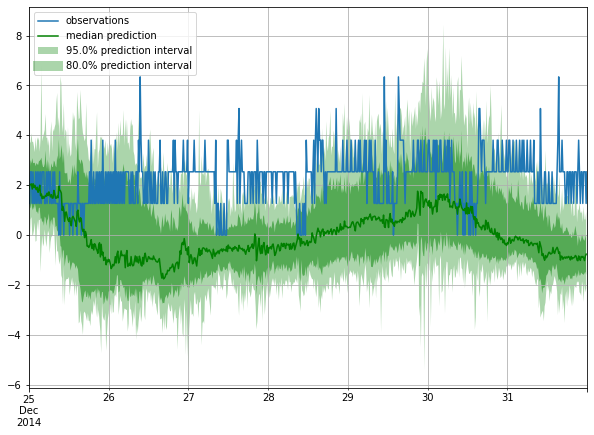

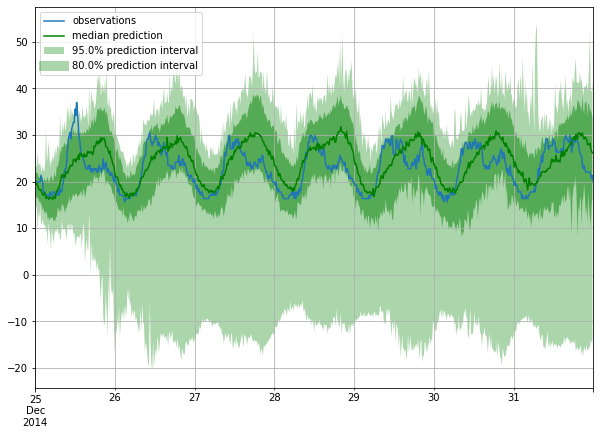

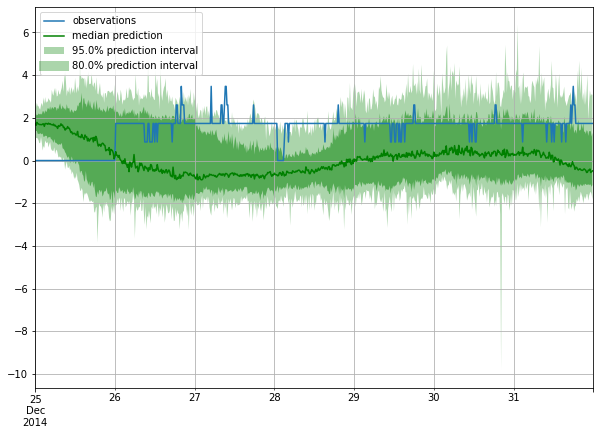

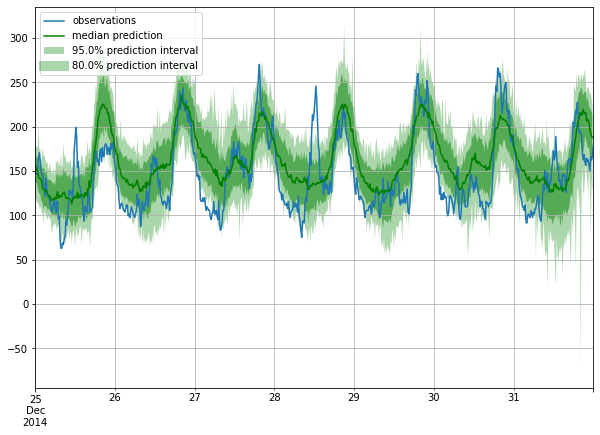

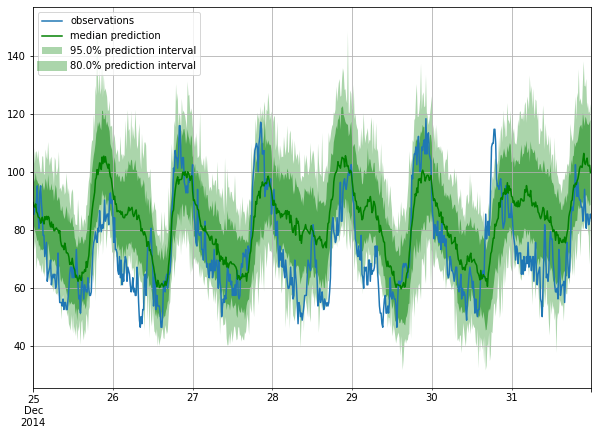

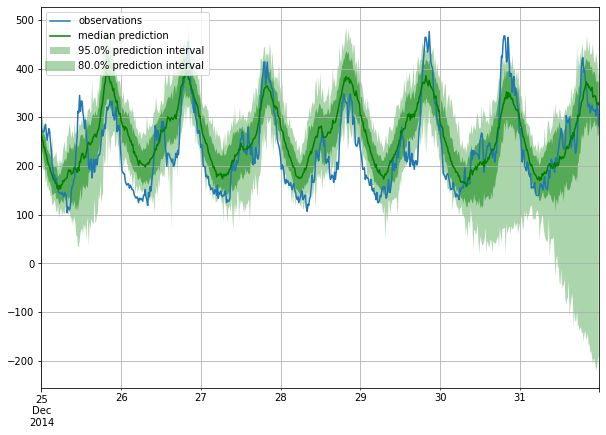

In [44]:
for i in tqdm(range(6)):
  ts_entry = tss[i]
  forecast_entry = forecasts[i]
  plot_prob_forecasts(ts_entry, forecast_entry)


In [45]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1,0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 7it [00:00, 63.08it/s]


In [46]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2014-12-25 00:00,6.305803,1580.313721,1513.959351,2.252916,0.931286,2.525173,1.042682,1.598567,1.043828,20.219106,467.488966,0.004464,1580.313724,0.062500,1190.991422,0.354167
1,None,2014-12-25 00:00,14.422471,2321.292969,15320.056641,22.797703,1.305572,2.645817,0.150817,0.143448,0.151520,34.551568,866.237659,0.005952,2321.292988,0.665179,1073.251674,0.950893
2,None,2014-12-25 00:00,2.917411,1189.324707,984.361450,1.464824,0.203948,8.677852,1.079991,1.786313,1.208220,36.643659,414.911971,0.066964,1189.324708,0.142857,443.129326,0.595238
3,None,2014-12-25 00:00,1044.892857,17861.488281,98455.281250,146.510835,16.799753,1.582142,0.205460,0.182855,0.181417,10.681330,10103.175984,0.436012,17861.489189,0.727679,7944.105402,0.921131
4,None,2014-12-25 00:00,245.221866,8768.897461,49303.656250,73.368536,7.521593,1.734866,0.193788,0.172945,0.177855,10.257303,4672.125196,0.427083,8768.897175,0.790179,3609.216903,0.938988
5,None,2014-12-25 00:00,3156.723214,31926.345703,157196.437500,233.923270,24.201930,1.963044,0.233368,0.204867,0.203098,15.283733,19516.894603,0.422619,31926.346954,0.724702,13419.699979,0.900298
6,None,2014-12-25 00:00,29.774867,3591.281738,3665.913086,5.455228,0.929394,5.750166,0.990639,1.504212,0.979642,20.955391,1083.444633,0.000000,3591.281737,0.034226,1414.449408,0.537202
